# Paper Section: Fig of the fine grain extrapolation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path

import sklearn
import numpy as np
import pandas as pd
from glob import glob

import matplotlib
import matplotlib.pyplot as plt

# Make all python scripts available in the path
sys.path.append('../')

import pp_utils
import lrn_crv_plot
%matplotlib inline

filepath = Path(os.getcwd())
print(filepath)

/vol/ml/apartin/projects/LearningCurves/notebooks


In [2]:
save_fig_path = filepath/'figs'
def save_fig(save_fig_path, fname):    
    plt.savefig(save_fig_path/(fname + '.eps'), format='eps')
    plt.savefig(save_fig_path/(fname + '.png'))

### Get dir path of all runs

In [3]:
src = 'gdsc_on_none'
base_dir = Path('/vol/ml/apartin/projects/LearningCurves/trn.gdsc/split_on_none/fine_grain_lgb_subset')
    
# Get all run dirs
runs = glob(str(base_dir/'*'))

### Aggregate results over runs

In [5]:
scores = []
for i, r in enumerate(runs):
    dpath = Path(r)/'lrn_crv_scores.csv'
    if not dpath.exists(): continue
        
    scr_tmp = pd.read_csv( dpath )
    scr_tmp.rename(columns={'fold0': 'run'+str(i+1)}, inplace=True)
    if len(scores)==0:
        scores = scr_tmp
    else:
        scores = scores.merge(scr_tmp, on=['metric', 'tr_size', 'set'])
        
run_col_names = [c for c in scores.columns if 'run' in c]

scores_mean   = scores[run_col_names].mean(axis=1)
scores_median = scores[run_col_names].median(axis=1)
scores_std    = scores[run_col_names].std(axis=1)

scores.insert(loc=3, column='mean', value=scores_mean)
scores.insert(loc=3, column='median', value=scores_median)
scores.insert(loc=3, column='std', value=scores_std)
print(len(np.unique(scores.tr_size)))

display(scores[:2])
print('Training set sizes:', np.unique(scores.tr_size))

save = True
if save:
    scores.to_csv(base_dir/'all_seed_runs_scores.csv', index=False)

93


,Unnamed: 0_x,metric,tr_size,std,median,mean,set,run1,Unnamed: 0_y,run2,...,Unnamed: 0_y,run5,Unnamed: 0_x,run6,Unnamed: 0_y,run7,Unnamed: 0_x,run8,Unnamed: 0_y,run9
0,0,mean_absolute_error,2,0.073099,0.039725,0.073975,tr,0.03565,0,0.188850,...,0,0.006750,0,0.02570,0,0.140400,0,0.043800,0,0.148000
1,1,mean_absolute_error,8,0.035035,0.102738,0.119389,tr,0.10680,1,0.094494,...,1,0.096544,1,0.08075,1,0.098675,1,0.171991,1,0.139644


Training set sizes: [    2     8    14    21    27    33    40    46    52    59    65    71
    78    84    90    97   103   109   116   122   129   135   141   148
   154   160   167   173   179   186   192   198   205   211   217   224
   230   236   243   249   256   300   702  1104  1506  1908  2310  2712
  3114  3516  3918  4321  4723  5125  5527  5929  6331  6733  7135  7537
  7939  8342  8744  9146  9548  9950 10352 10754 11156 11558 11960 12363
 12765 13167 13569 13971 14373 14775 15177 15579 15981 16384 32768 38291
 43814 49337 54860 60384 65907 71430 76953 82476 88000]


In [6]:
scores_te = scores[(scores.metric=='mean_absolute_error') & (scores.set=='te')].reset_index(drop=True).iloc[:, :6]
scores_te.to_csv(base_dir/'scores.csv', index=False)

In [7]:
figsize = (6, 4.5)
metric_name = 'mean_absolute_error'
tr_set = 'te'

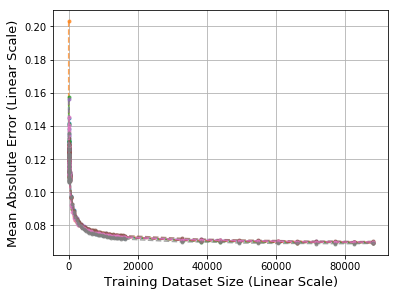

In [11]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'linear', 'ytick_scale': 'linear'}
shard_min_idx=0
# shard_min_idx=1

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );
# plt.savefig(save_fig_path/f'{src}_all_runs_linlin_scale.png')

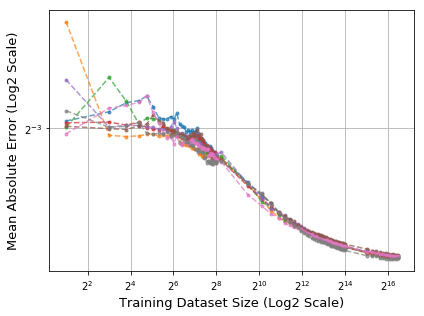

In [12]:
plot_args = {'tr_set': tr_set, 'metric_name': metric_name, 'figsize': figsize, 'xtick_scale': 'log2', 'ytick_scale': 'log2'}
shard_min_idx=0
# shard_min_idx=1

ax = pp_utils.plot_lc_multi_runs( runs, shard_min_idx=shard_min_idx, **plot_args );
plt.tight_layout()
# plt.savefig(save_fig_path/f'{src}_all_runs_loglog_scale.png')

- STD of scores across runs is inversely proportional to the subset size. This can be attributed to the distribution similarity of target values between training subset and test set. The target values, is our use case, are the dose-independent values. The smaller the subset, the lower the similarity with a test set, and therefore, we observe larger variance of scores across runs [shuffles/experiments] at smaller subsets.
- We exploit this observation for ... [Mukherjee exploits this observation ...]

In [13]:
figsize = (6, 4.5)
# figsize = (10, 8)
metric_name = 'mean_absolute_error'
xtick_scale, ytick_scale = 'log2', 'log2'

plot_args = {'metric_name': metric_name, 'xtick_scale': xtick_scale, 'ytick_scale': xtick_scale, 'figsize': figsize}

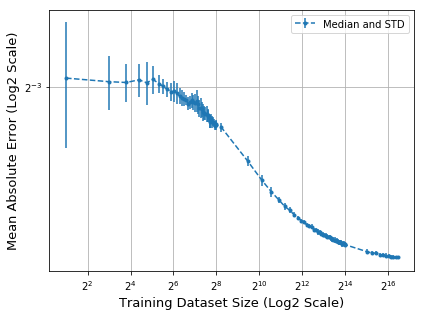

In [14]:
scores_te = scores[ (scores['metric']==metric_name) & (scores['set']=='te') ].reset_index(drop=True)

shard_min_idx=0
# shard_min_idx=1

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te['median'][shard_min_idx:], yerr=scores_te['std'][shard_min_idx:],
        ax=ax, ls='--', marker='.', alpha=1,
        **plot_args, label='Median and STD')

ax.legend(frameon=True, fontsize=10, loc='best');
plt.tight_layout()
# plt.savefig(save_fig_path/f'{src}_agg_median_std.png')

GOF: {'rmse': 0.000856417743984046, 'mae': 0.0006562799009453333}


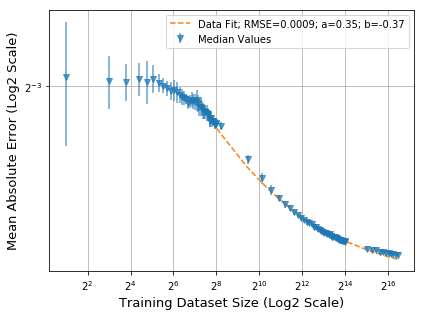

In [17]:
tot_pnts = len(scores_te['tr_size'])
n_pnts_fit = 70 # Number of points to use for curve fitting starting from the largest size

y_col_name = 'median'

ax = None

ax = lrn_crv_plot.plot_lrn_crv_new(
        x=scores_te['tr_size'][0:], y=scores_te[y_col_name][0:], yerr=scores_te['std'][0:],
        ax=ax, ls='', marker='v', alpha=0.7,
        **plot_args, label='Median Values')

shard_min_idx = 0 if tot_pnts < n_pnts_fit else tot_pnts - n_pnts_fit

ax, _, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scores_te['tr_size'][shard_min_idx:], y=scores_te[y_col_name][shard_min_idx:],
        **plot_args, plot_raw=False, ax=ax, alpha=1 );

ax.legend(frameon=True, fontsize=10, loc='best')
plt.tight_layout()
# plt.savefig(save_fig_path/f'{src}_agg_median_std_fit_subset_points.png')

print('GOF:', gof)

# Fig: Fine-grain extrapolation

fit_min_id=0, m=129
fit_max_id=22, m=702
ext=22, m=11960
Extrapolation MAE 0.003977130022489908


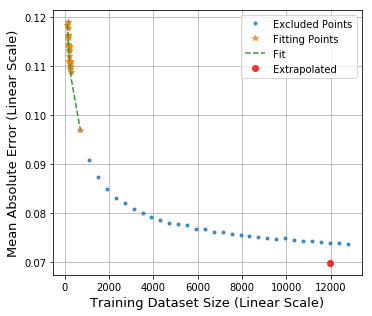

In [25]:
scr = scores_te.copy()
# scr = scores_te.copy().reset_index(drop=True)
# scr = scores_te.copy().iloc[5:, :].reset_index(drop=True)
shift = 0
shift = 20
scr = scores_te.copy().iloc[shift:-20, :].reset_index(drop=True)
# plot_args['figsize'] = (11, 8)
plot_args['figsize'] = (7, 4.5)
tot_pnts = len(scr['tr_size'])
# fit_min = 20  # good start
# fit_max = 42  # good end

fit_min = 20-shift  # good start
fit_max = 42-shift  # good end

y_col_name = 'median'
plot_args['xtick_scale'], plot_args['ytick_scale'] = 'linear', 'linear'
# plot_args['xtick_scale'], plot_args['ytick_scale'] = 'log2', 'log2'

ax = None
ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr['tr_size'], y = scr[y_col_name], # yerr = scr['std'],
        ax=ax, ls='', marker='.', alpha=0.8, # color='k',
        **plot_args, label='Excluded Points')

ax = lrn_crv_plot.plot_lrn_crv_new(
        x = scr.loc[fit_min:fit_max, 'tr_size'], y = scr.loc[fit_min:fit_max, y_col_name], # yerr = scr.loc[fit_min:fit_max, 'std'],
        ax=ax, ls='', marker='*', alpha=0.8, # color='c',
        **plot_args, label='Fitting Points')

ax, fit_prms, gof = lrn_crv_plot.plot_lrn_crv_power_law(
        x=scr.loc[fit_min:fit_max, 'tr_size'], y=scr.loc[fit_min:fit_max, y_col_name],
        **plot_args, plot_raw=False, ax=ax, alpha=1 );

print('fit_min_id={}, m={}'.format(fit_min, scr.loc[fit_min, 'tr_size']))
print('fit_max_id={}, m={}'.format(fit_max, scr.loc[fit_max, 'tr_size']))
# x_ext = 52-shift  # good extrapolation -->
x_ext = 70-shift  # bad extrapolation -->
print('ext={}, m={}'.format(fit_max, scr.loc[x_ext, 'tr_size']))
y_ext = lrn_crv_plot.power_law_func_3prm(x=scr.loc[x_ext, 'tr_size'], **fit_prms)

ext_mae = abs(y_ext - scr.loc[x_ext, y_col_name])
print('Extrapolation MAE', ext_mae)

ax = lrn_crv_plot.plot_lrn_crv_new(
        x = np.array(scr.loc[x_ext, 'tr_size']), y = y_ext,
        ax=ax, ls='', marker='o', alpha=0.8, color='r',
        **plot_args, label='Extrapolated')

plt.tight_layout()
ax.legend(frameon=True, fontsize=10, loc='best')
save_fig(save_fig_path, fname=f'{src}_fine_grain_extrap_linling')